# Parsing xml masks

Binary masks in the Kumar dataset are given in xml format that encodes all the vertices of the annotated cells (polygons). This notebook parses the xml-masks and converts them to binary images.

In [11]:
# import os
# import cv2
# import xml.etree.ElementTree as ET
# import numpy as np
# from shapely.geometry import Polygon
# from skimage import draw
# import matplotlib.pyplot as plt
# import ipywidgets as widgets
# from bqplot import *
# import bqplot.pyplot as bqp

In [12]:
# image_path = "/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/test/Tissue_images/"
# data_path = "/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/test/Annotations_xml/"
# destination_path = "/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/test/"

In [18]:
# patients = [files for path, subdirs, files in os.walk(data_path)]
# patients = patients[0]
# patients

# Here happens the xml parsing

the images are of shape 1000x1000 so we want the masks to be the same size.

In [4]:
# img_shape = (1000, 1000)
# 
# for i, xml_fn in enumerate(patients):
#     print("patient: {}, image {}".format(xml_fn, i+1))
#     
#     # Open the xml file
#     tree = ET.parse(data_path+xml_fn)
#     root = tree.getroot()
#     # Initialize the binary mask
#     binary_mask = np.zeros(img_shape, dtype=np.uint8)
#     print("mask shape: {}".format(binary_mask.shape))
#     
#     # Parse the xml file
#     for child in root:
#         for attribs in child:
#             for el in attribs:
#                 if el.tag == "Attributes":
#                     pass
#                     
#                 # Go through every annotated region in one image    
#                 if el.tag == "Region":
#                     vertices = el[1]
#                     
#                     # Initialize coordinates matrix (x, y)
#                     coords = np.zeros((len(vertices), 2))
#     
#                     # go through each vertex in vertices
#                     for i, vertex in enumerate(vertices):
#                         coords[i][0] = vertex.attrib['X']
#                         coords[i][1] = vertex.attrib['Y']
#                     
#                     # Create polygon objects from the coordinates of the region         
#                     vertex_row_coords = coords[:,0]
#                     vertex_col_coords = coords[:,1]
#                     
#                     # Draw the polygon from the coordinates
#                     fill_row_coords, fill_col_coords = draw.polygon(
#                         vertex_col_coords, 
#                         vertex_row_coords, 
#                         binary_mask.shape
#                     )
#                     
#                     # Fill the binary mask with binary values based on the coords
#                     binary_mask[fill_row_coords, fill_col_coords] = 255
#                     # print(binary_mask.shape)
#                     # Save the binary mask
#                     mask_path = destination_path+'/'+xml_fn[:-4]+'_mask.png'
#                     cv2.imwrite(mask_path, binary_mask)
#                     

# HoVerNet REPO-style

# This has instance label idxs

In [15]:
##
## For processing .xml annotation file in Kumar dataset
##
from skimage import draw
import matplotlib.pyplot as plt
import ipywidgets as widgets
import glob
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import scipy.io


###
imgs_dir = "/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/" # .png
anns_dir = "/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Annotations_xml/" # .xml folders
save_dir = "/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/" # storing .png ground truth (HW)

file_list = glob.glob(imgs_dir + '*.png')
file_list.sort() # ensure same order [1]

for filename in file_list: # png for base
    filename = os.path.basename(filename)
    basename = filename.split('.')[0]

    print(basename)
    img = cv2.imread(imgs_dir + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    hw = img.shape[:2]

    xml = ET.parse(anns_dir + basename + '.xml')

    contour_dbg = np.zeros(hw, np.uint8)

    insts_list = []
    for idx, region_xml in enumerate(xml.findall('.//Region')):
        vertices = []
        for vertex_xml in region_xml.findall('.//Vertex'):
            attrib = vertex_xml.attrib
            vertices.append([float(attrib['X']), 
                             float(attrib['Y'])])
        vertices = np.array(vertices) + 0.5
        vertices = vertices.astype('int32')
        contour_blb = np.zeros(hw, np.uint8)
        
        # fill both the inner area and contour with idx+1 color
        cv2.drawContours(contour_blb, [vertices], 0, idx+1, -1)
        insts_list.append(contour_blb)

    insts_size_list = np.array(insts_list)
    insts_size_list = np.sum(insts_size_list, axis=(1 , 2))
    insts_size_list = list(insts_size_list)

    pair_insts_list = zip(insts_list, insts_size_list)
    
    # sort in z-axis basing on size, larger on top
    pair_insts_list = sorted(pair_insts_list, key=lambda x: x[1])
    insts_list, insts_size_list = zip(*pair_insts_list)

    ann = np.zeros(hw, np.int32)
    for idx, inst_map in enumerate(insts_list):
        ann[inst_map > 0] = idx + 1

    mask_fn = save_dir+'/'+basename+'_mask.mat'
    # np.save('%s/%s_mask.npy' % (save_dir, basename), ann)
    scipy.io.savemat(mask_fn, mdict={'inst_map': ann})

TCGA-18-5592-01Z-00-DX1
TCGA-21-5784-01Z-00-DX1
TCGA-21-5786-01Z-00-DX1
TCGA-38-6178-01Z-00-DX1
TCGA-49-4488-01Z-00-DX1
TCGA-50-5931-01Z-00-DX1
TCGA-A7-A13E-01Z-00-DX1
TCGA-A7-A13F-01Z-00-DX1
TCGA-AR-A1AK-01Z-00-DX1
TCGA-AR-A1AS-01Z-00-DX1
TCGA-AY-A8YK-01A-01-TS1
TCGA-B0-5698-01Z-00-DX1
TCGA-B0-5710-01Z-00-DX1
TCGA-B0-5711-01Z-00-DX1
TCGA-CH-5767-01Z-00-DX1
TCGA-DK-A2I6-01A-01-TS1
TCGA-E2-A14V-01Z-00-DX1
TCGA-E2-A1B5-01Z-00-DX1
TCGA-G2-A2EK-01A-02-TSB
TCGA-G9-6336-01Z-00-DX1
TCGA-G9-6348-01Z-00-DX1
TCGA-G9-6356-01Z-00-DX1
TCGA-G9-6362-01Z-00-DX1
TCGA-G9-6363-01Z-00-DX1
TCGA-HE-7128-01Z-00-DX1
TCGA-HE-7129-01Z-00-DX1
TCGA-HE-7130-01Z-00-DX1
TCGA-KB-A93J-01A-01-TS1
TCGA-NH-A8F7-01A-01-TS1
TCGA-RD-A8N9-01A-01-TS1


# Check that the masks look correct

/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/test/Tissue_images/
/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/
(1000, 1000, 3)
(1000, 1000)


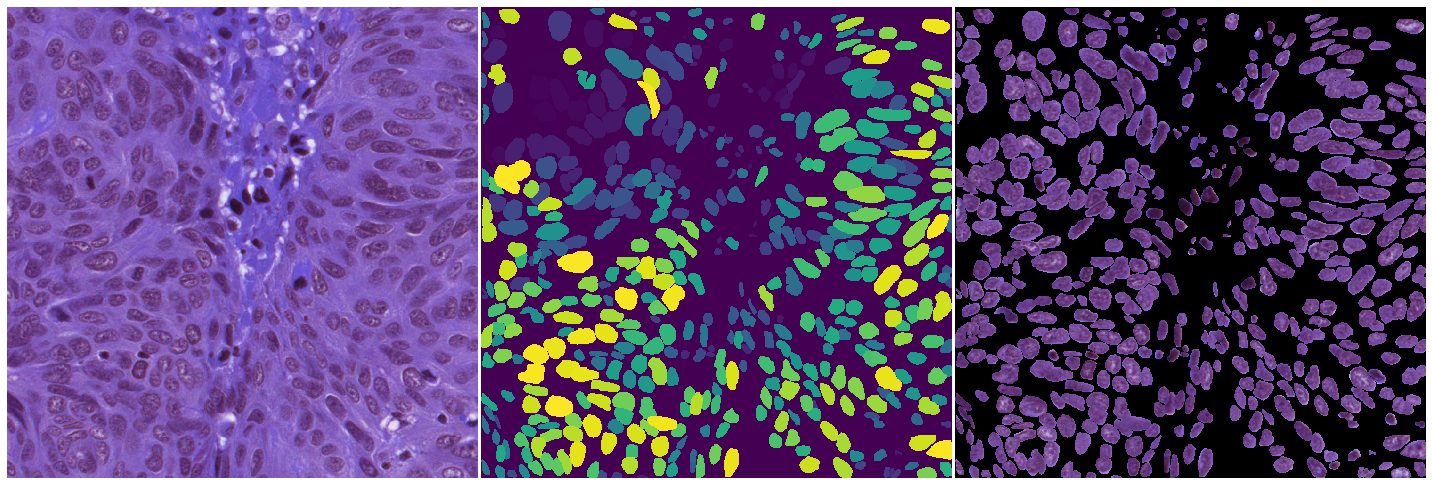

In [16]:
# Superimpose a mask onto the original to check
img = cv2.imread(imgs_dir + "TCGA-18-5592-01Z-00-DX1.png")
mask = scipy.io.loadmat(save_dir + "TCGA-18-5592-01Z-00-DX1_mask.mat")
mask = mask['inst_map']
# added_image = cv2.addWeighted(img, 1, mask, 0.6, 0.5)
image_overlayed = np.where(mask[..., None], img, 0)
print(image_path)
print(save_dir)
print(img.shape)
print(mask.shape)
plt.subplots(1, 3 ,figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(img, interpolation='none')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(mask, interpolation='none')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(image_overlayed, interpolation='none')
plt.axis('off')
plt.tight_layout(w_pad=0.3, h_pad=0.3)

(1000, 1000)
[0. 1.]
[0 1]
(1000, 1000)


/home/leos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


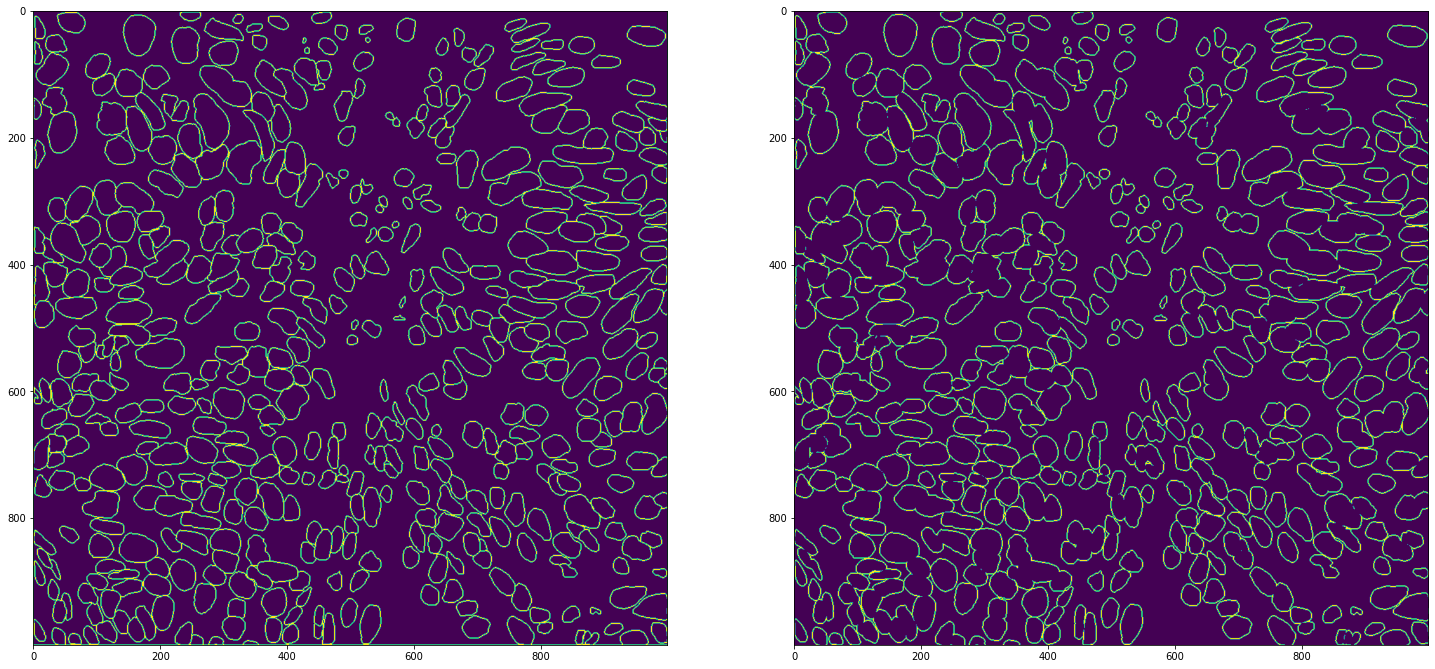

In [17]:
from scipy.ndimage.morphology import binary_dilation

def bounding_box(img):
    """
    Bounding box coordinates for nuclei instance
    that is given as input.
    """
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    # due to python indexing, need to add 1 to max
    # else accessing will be 1px in the box, not out 
    rmax += 1
    cmax += 1
    return [rmin, rmax, cmin, cmax]

def instance_contours(label_img, thickness=2):
    bg = np.zeros(label_img.shape, dtype=np.uint8)
    for j, nuc_id in enumerate(np.unique(label_img)):
        inst_map = np.array(label_img == nuc_id, np.uint8)
        y1, y2, x1, x2  = bounding_box(inst_map)
        y1 = y1 - 2 if y1 - 2 >= 0 else y1 
        x1 = x1 - 2 if x1 - 2 >= 0 else x1 
        x2 = x2 + 2 if x2 + 2 <= label_img.shape[1] - 1 else x2 
        y2 = y2 + 2 if y2 + 2 <= label_img.shape[0] - 1 else y2
        inst_map_crop = inst_map[y1:y2, x1:x2]
        inst_bg_crop = bg[y1:y2, x1:x2]
        contours, hierarchy = cv2.findContours(inst_map_crop, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contoured_rgb = cv2.drawContours(inst_bg_crop, contours, contourIdx=-1, color=(255, 255, 255), thickness=thickness)
        bg[y1:y2, x1:x2] = inst_bg_crop
    
    return bg

contours = instance_contours(mask, thickness=1)
print(contours.shape)
print(np.unique(contours/255))

ww = mask.copy()
ww[ww != 0] = 1
print(np.unique(ww))
weight = binary_dilation(ww == 1 , iterations=2) & ~ww

print(weight.shape)

fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].imshow(contours)
ax[1].imshow(weight)
fig.show()